In [1]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

In [2]:
import pickle

posts = []
with open ('processed_posts.pkl', 'rb') as fp:
    posts = pickle.load(fp)

In [3]:
tokenized_posts = []

for post in posts:
    user = []
    for sentence in post:
        user += sentence.split(" ")
        
    tokenized_posts.append(user)

In [4]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [5]:
from collections import Counter

In [6]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [7]:
dictionary = list(zip(*dictionary))[0]

In [8]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [9]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [10]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

def to_one_hot(arr):
    one_hot_types = []

    for label in arr:
        bin_type = []

        if (label[0] == 'I'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[1] == 'N'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[2] == 'T'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[3] == 'J'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        one_hot_types.append(bin_type)
        
    return one_hot_types
    

In [11]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x = vectorize_sequences(x_vals)
y = np.asarray(to_one_hot(labels)).astype('float32')

Using TensorFlow backend.


In [12]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [13]:
x_test = x[:1000]
y_test = y[:1000]

x_train = x[1000:]
y_train = y[1000:]

x_val = x_train[:500]
y_val = y_train[:500]

partial_x_train = x_train[500:]
partial_y_train = y_train[500:]

In [14]:
#These are for full label prediction
class_weights = [{0:1, 1:8}, {0:1, 1:6.24}, {0:1, 1:1.18}, {0:1, 1:0.65}]

In [15]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras.regularizers import l2
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [28]:
from keras.callbacks import Callback

class MultiLabelAccuracy(Callback):
    
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.accuracy = []
        
    def getAccuracy(self, prediction):
        y_true = self.validation_data[1]
        
        correct = []
        total = []
        accuracy = []
        
        for i in range(0, len(y_true[0])):
            correct.append([0, 0])
            total.append([0, 0])
        
        for sample in range(0, len(prediction)):
            for neuron in range(0, len(prediction[sample])):
                
                if (y_true[sample][neuron] == 0.0):
                    if (round(prediction[sample][neuron]) == y_true[sample][neuron]):
                        correct[neuron][0] += 1
                    total[neuron][0] += 1
                    
                if (y_true[sample][neuron] == 1.0):
                    if (round(prediction[sample][neuron]) == y_true[sample][neuron]):
                        correct[neuron][1] += 1
                    total[neuron][1] += 1
        
        for neuron in range(0, len(correct)):
            accuracy.append((correct[neuron][0]/total[neuron][0],
                                  correct[neuron][1]/total[neuron][1]))
            
        return accuracy
                    
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.validation_data[0])
        epoch_data = self.getAccuracy(y_pred)
        self.accuracy.append(epoch_data)
        
        for i in range(0, len(epoch_data)):
            print("Neuron #"+ str(i))
            print("Zero Accuracy:", epoch_data[i][0])
            print("Ones Accuracy:", epoch_data[i][1])
                
    

In [ ]:
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = MultiLabelAccuracy((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data= (x_val, y_val),
                        epochs = 800, batch_size = 2048,
                        class_weight=class_weights,
                        callbacks=[true_metrics])

Train on 7175 samples, validate on 500 samples
Epoch 1/800
7175/7175 [==============================] - 1s 176us/step - loss: 0.6596 - acc: 0.6392 - val_loss: 0.5947 - val_acc: 0.6845
Neuron #0
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #2
Zero Accuracy: 0.0
Ones Accuracy: 1.0
Neuron #3
Zero Accuracy: 0.6052631578947368
Ones Accuracy: 0.5483870967741935
Epoch 2/800
7175/7175 [==============================] - 1s 117us/step - loss: 0.5830 - acc: 0.6878 - val_loss: 0.6001 - val_acc: 0.6470
Neuron #0
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #2
Zero Accuracy: 0.0
Ones Accuracy: 1.0
Neuron #3
Zero Accuracy: 0.9421052631578948
Ones Accuracy: 0.1
Epoch 3/800
7175/7175 [==============================] - 1s 129us/step - loss: 0.5785 - acc: 0.6748 - val_loss: 0.5831 - val_acc: 0.6720
Neuron #0
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #2
Zero Ac

7175/7175 [==============================] - 1s 103us/step - loss: 0.4187 - acc: 0.8106 - val_loss: 0.5299 - val_acc: 0.7365
Neuron #0
Zero Accuracy: 0.9820971867007673
Ones Accuracy: 0.08256880733944955
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #2
Zero Accuracy: 0.7074235807860262
Ones Accuracy: 0.7638376383763837
Neuron #3
Zero Accuracy: 0.6842105263157895
Ones Accuracy: 0.5129032258064516
Epoch 23/800
7175/7175 [==============================] - 1s 101us/step - loss: 0.4196 - acc: 0.8055 - val_loss: 0.5432 - val_acc: 0.7285
Neuron #0
Zero Accuracy: 0.9948849104859335
Ones Accuracy: 0.01834862385321101
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.0
Neuron #2
Zero Accuracy: 0.7336244541484717
Ones Accuracy: 0.7453874538745388
Neuron #3
Zero Accuracy: 0.7736842105263158
Ones Accuracy: 0.4096774193548387
Epoch 24/800
7175/7175 [==============================] - 1s 101us/step - loss: 0.4190 - acc: 0.8006 - val_loss: 0.5378 - val_acc: 0.7335
Neuron #0
Zero Accuracy: 0.959079

7175/7175 [==============================] - 1s 116us/step - loss: 0.3220 - acc: 0.8667 - val_loss: 0.5168 - val_acc: 0.7500
Neuron #0
Zero Accuracy: 0.948849104859335
Ones Accuracy: 0.21100917431192662
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.02564102564102564
Neuron #2
Zero Accuracy: 0.7816593886462883
Ones Accuracy: 0.7564575645756457
Neuron #3
Zero Accuracy: 0.6526315789473685
Ones Accuracy: 0.5612903225806452
Epoch 42/800
7175/7175 [==============================] - 1s 134us/step - loss: 0.3202 - acc: 0.8649 - val_loss: 0.5375 - val_acc: 0.7385
Neuron #0
Zero Accuracy: 0.9386189258312021
Ones Accuracy: 0.22935779816513763
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.02564102564102564
Neuron #2
Zero Accuracy: 0.868995633187773
Ones Accuracy: 0.6346863468634686
Neuron #3
Zero Accuracy: 0.7526315789473684
Ones Accuracy: 0.47419354838709676
Epoch 43/800
7175/7175 [==============================] - 1s 135us/step - loss: 0.3110 - acc: 0.8741 - val_loss: 0.5178 - val_acc: 0.7495
Ne

7175/7175 [==============================] - 1s 100us/step - loss: 0.2360 - acc: 0.9189 - val_loss: 0.5265 - val_acc: 0.7560
Neuron #0
Zero Accuracy: 0.9258312020460358
Ones Accuracy: 0.27522935779816515
Neuron #1
Zero Accuracy: 1.0
Ones Accuracy: 0.038461538461538464
Neuron #2
Zero Accuracy: 0.8034934497816594
Ones Accuracy: 0.7527675276752768
Neuron #3
Zero Accuracy: 0.6263157894736842
Ones Accuracy: 0.6064516129032258
Epoch 61/800
7175/7175 [==============================] - 1s 98us/step - loss: 0.2307 - acc: 0.9232 - val_loss: 0.5336 - val_acc: 0.7505
Neuron #0
Zero Accuracy: 0.948849104859335
Ones Accuracy: 0.1926605504587156
Neuron #1
Zero Accuracy: 0.995260663507109
Ones Accuracy: 0.0641025641025641
Neuron #2
Zero Accuracy: 0.7729257641921398
Ones Accuracy: 0.7785977859778598
Neuron #3
Zero Accuracy: 0.6947368421052632
Ones Accuracy: 0.5290322580645161
Epoch 62/800
7175/7175 [==============================] - 1s 99us/step - loss: 0.2341 - acc: 0.9188 - val_loss: 0.5370 - val_acc

7175/7175 [==============================] - 1s 103us/step - loss: 0.1719 - acc: 0.9527 - val_loss: 0.5467 - val_acc: 0.7555
Neuron #0
Zero Accuracy: 0.9130434782608695
Ones Accuracy: 0.3119266055045872
Neuron #1
Zero Accuracy: 0.990521327014218
Ones Accuracy: 0.10256410256410256
Neuron #2
Zero Accuracy: 0.8122270742358079
Ones Accuracy: 0.7527675276752768
Neuron #3
Zero Accuracy: 0.6105263157894737
Ones Accuracy: 0.6064516129032258
Epoch 80/800
7175/7175 [==============================] - 1s 99us/step - loss: 0.1644 - acc: 0.9588 - val_loss: 0.5636 - val_acc: 0.7510
Neuron #0
Zero Accuracy: 0.9360613810741688
Ones Accuracy: 0.23853211009174313
Neuron #1
Zero Accuracy: 0.9834123222748815
Ones Accuracy: 0.14102564102564102
Neuron #2
Zero Accuracy: 0.7903930131004366
Ones Accuracy: 0.7601476014760148
Neuron #3
Zero Accuracy: 0.7157894736842105
Ones Accuracy: 0.5193548387096775
Epoch 81/800
7175/7175 [==============================] - 1s 100us/step - loss: 0.1783 - acc: 0.9454 - val_loss:

Neuron #0
Zero Accuracy: 0.9104859335038363
Ones Accuracy: 0.30275229357798167
Neuron #1
Zero Accuracy: 0.981042654028436
Ones Accuracy: 0.15384615384615385
Neuron #2
Zero Accuracy: 0.7947598253275109
Ones Accuracy: 0.7416974169741697
Neuron #3
Zero Accuracy: 0.6421052631578947
Ones Accuracy: 0.5774193548387097
Epoch 98/800
7175/7175 [==============================] - 1s 101us/step - loss: 0.1136 - acc: 0.9810 - val_loss: 0.5727 - val_acc: 0.7550
Neuron #0
Zero Accuracy: 0.9104859335038363
Ones Accuracy: 0.30275229357798167
Neuron #1
Zero Accuracy: 0.981042654028436
Ones Accuracy: 0.15384615384615385
Neuron #2
Zero Accuracy: 0.74235807860262
Ones Accuracy: 0.8154981549815498
Neuron #3
Zero Accuracy: 0.5105263157894737
Ones Accuracy: 0.667741935483871
Epoch 99/800
7175/7175 [==============================] - 1s 100us/step - loss: 0.1061 - acc: 0.9858 - val_loss: 0.5938 - val_acc: 0.7545
Neuron #0
Zero Accuracy: 0.928388746803069
Ones Accuracy: 0.28440366972477066
Neuron #1
Zero Accuracy

7175/7175 [==============================] - 1s 100us/step - loss: 0.0961 - acc: 0.9792 - val_loss: 0.6382 - val_acc: 0.7385
Neuron #0
Zero Accuracy: 0.8618925831202046
Ones Accuracy: 0.4036697247706422
Neuron #1
Zero Accuracy: 0.9881516587677726
Ones Accuracy: 0.10256410256410256
Neuron #2
Zero Accuracy: 0.8384279475982532
Ones Accuracy: 0.6346863468634686
Neuron #3
Zero Accuracy: 0.531578947368421
Ones Accuracy: 0.6645161290322581
Epoch 117/800
7175/7175 [==============================] - 1s 100us/step - loss: 0.0749 - acc: 0.9926 - val_loss: 0.6280 - val_acc: 0.7535
Neuron #0
Zero Accuracy: 0.887468030690537
Ones Accuracy: 0.3486238532110092
Neuron #1
Zero Accuracy: 0.9834123222748815
Ones Accuracy: 0.15384615384615385
Neuron #2
Zero Accuracy: 0.7510917030567685
Ones Accuracy: 0.7896678966789668
Neuron #3
Zero Accuracy: 0.48947368421052634
Ones Accuracy: 0.6967741935483871
Epoch 118/800
7175/7175 [==============================] - 1s 98us/step - loss: 0.0672 - acc: 0.9954 - val_loss

Neuron #0
Zero Accuracy: 0.8849104859335039
Ones Accuracy: 0.3669724770642202
Neuron #1
Zero Accuracy: 0.976303317535545
Ones Accuracy: 0.20512820512820512
Neuron #2
Zero Accuracy: 0.7379912663755459
Ones Accuracy: 0.7896678966789668
Neuron #3
Zero Accuracy: 0.47368421052631576
Ones Accuracy: 0.7064516129032258
Epoch 135/800
7175/7175 [==============================] - 1s 98us/step - loss: 0.0450 - acc: 0.9984 - val_loss: 0.6899 - val_acc: 0.7555
Neuron #0
Zero Accuracy: 0.8900255754475703
Ones Accuracy: 0.3302752293577982
Neuron #1
Zero Accuracy: 0.9739336492890995
Ones Accuracy: 0.21794871794871795
Neuron #2
Zero Accuracy: 0.7030567685589519
Ones Accuracy: 0.8339483394833949
Neuron #3
Zero Accuracy: 0.41578947368421054
Ones Accuracy: 0.7516129032258064
Epoch 136/800
7175/7175 [==============================] - 1s 98us/step - loss: 0.0520 - acc: 0.9962 - val_loss: 0.7840 - val_acc: 0.7480
Neuron #0
Zero Accuracy: 0.9335038363171355
Ones Accuracy: 0.24770642201834864
Neuron #1
Zero Acc

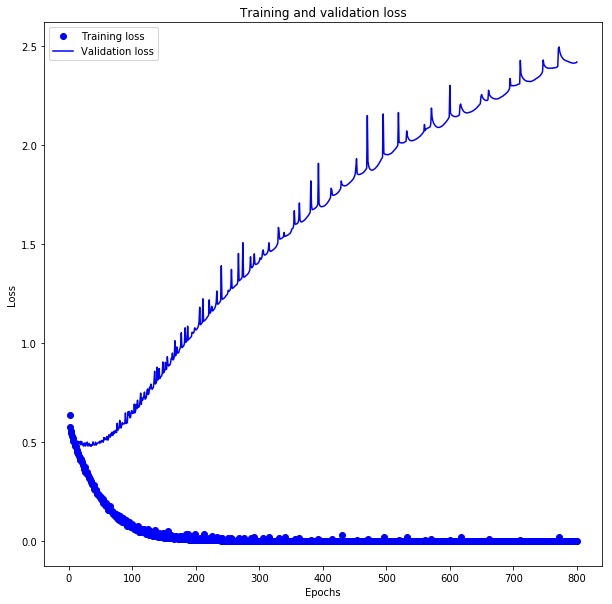

<Figure size 432x288 with 0 Axes>

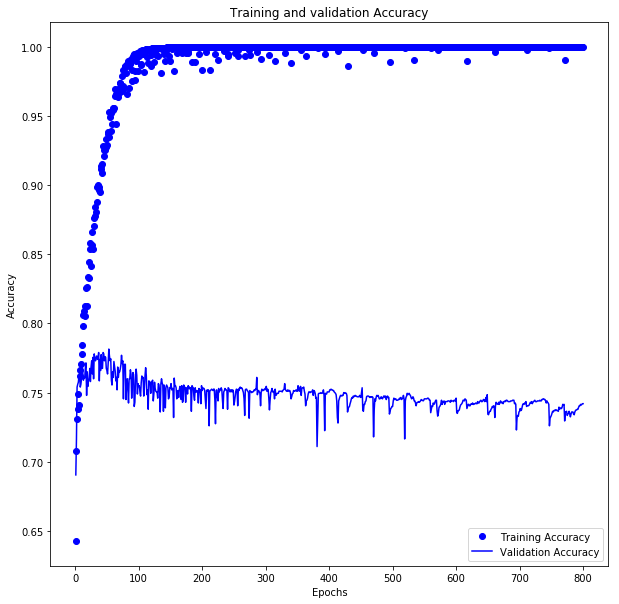

In [77]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.figure(figsize=(10,10))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(10,10))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs = 50, batch_size = 512, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/50
7675/7675 [==============================] - 1s 152us/step - loss: 0.7379 - acc: 0.5347
Epoch 2/50
7675/7675 [==============================] - 1s 83us/step - loss: 0.6720 - acc: 0.5866
Epoch 3/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.6287 - acc: 0.6748
Epoch 4/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.5815 - acc: 0.7410
Epoch 5/50
7675/7675 [==============================] - 1s 85us/step - loss: 0.5127 - acc: 0.8044
Epoch 6/50
7675/7675 [==============================] - 1s 80us/step - loss: 0.4471 - acc: 0.8236
Epoch 7/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.3727 - acc: 0.8650
Epoch 8/50
7675/7675 [==============================] - 1s 82us/step - loss: 0.3509 - acc: 0.8782
Epoch 9/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.3199 - acc: 0.8946
Epoch 10/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.2976 - acc: 0.8984
Epoch 11/50
7675/7

[0.9689026575088501, 0.749]

Normalized confusion matrix


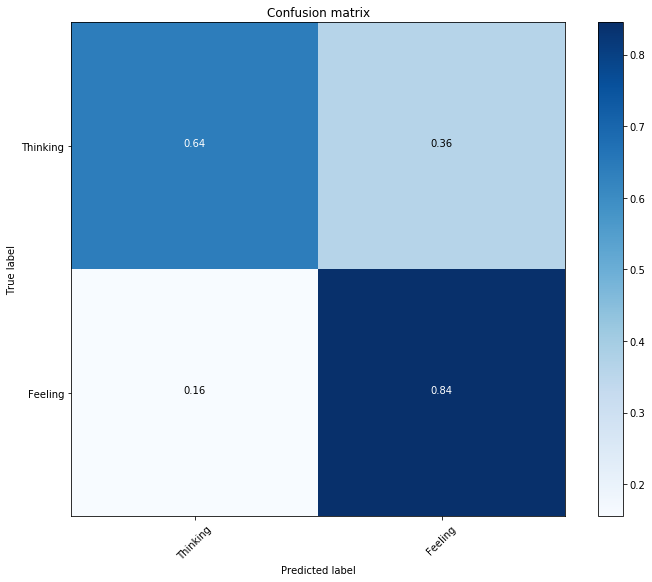

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

#decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
#decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

decoded_y_true = y_test.round()
decoded_y_pred = y_pred.round()

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=[0, 1])
#matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
#matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
#matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
#matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(10,8))
plot_confusion_matrix(matrix, classes=["Thinking","Feeling"], normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

#plt.clf()
#plt.figure(figsize=(5,5))
#plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
#                      title='I-E Confusion matrix')
#name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
#plt.savefig(name)
#plt.show()
#pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
#                          title='N-S Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
#    plt.savefig(name)
#    plt.show()
#   pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
#                          title='T-F Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
#    plt.savefig(name)
#    plt.show()
#    pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
#                          title='J-P Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
#    plt.savefig(name)
#    plt.show()
#    pictures.append(name)